# 初始spark設定(每台不同)

In [1]:
import os
import sys
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH/lib/spark/'

In [2]:
import findspark
findspark.init()

# 欄位資訊

In [3]:
with open("col_info.txt", "r") as f:
    head = f.readline()
    col_info = [ line.strip().split(" ") for line in f.read().split("\n")]

In [4]:
col_info[:5]

[['0', 'Year', 'int', '飛行日期_年', 'X'],
 ['1', 'Month', 'int', '飛行日期_月', 'O', '一月和十二月特別容易取消班機'],
 ['2', 'DayofMonth', 'int', '飛行日期_日', 'O', '25,11,18,13號', '特別容易取消班機'],
 ['3', 'DayOfWeek', 'int', '飛行日期_星期', 'O', '星期二特別容易取消班機,星期日最不容易取消班機'],
 ['4', 'DepTime', 'int', '飛行時間_起飛時間', 'X', "如果班機取消,這個值必為'NA',不可選"]]

# 讀取資料

In [5]:
from pyspark.conf import SparkConf
conf = SparkConf()

In [6]:
conf.setMaster("yarn")
conf.set("spark.executor.memory", "36g")
conf.set("spark.driver.memory", "36g")
conf.set("spark.cores.max", "9")

In [7]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [8]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [9]:
SELECED_COLS_CATAG = ['UniqueCarrier', 'Origin', 'Dest', 'FlightNum']
SELECED_COLS_FLOAT = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',  'CRSArrTime', 'CRSElapsedTime', 'Distance']
LABEL_COL = 'Cancelled'

In [10]:
from pyspark.sql.types import *

schema = StructType([
    StructField(ci[1], IntegerType() if ci[2]=='int' else StringType() , False) for ci in col_info ])#schema定義匯入欄位的資料型態

df = sqlContext.read.format('com.databricks.spark.csv') \
        .options(header='true', inferschema='true') \
        .schema(schema) \
        .load('200[0-5].csv') \
        .select(['Year']+SELECED_COLS_CATAG+SELECED_COLS_FLOAT+[LABEL_COL]) #截取部分欄位之資料

In [11]:
%%time
df.take(1)

CPU times: user 3.91 ms, sys: 1.85 ms, total: 5.76 ms
Wall time: 5.64 s


[Row(Year=2000, UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, CRSArrTime=1859, CRSElapsedTime=252, Distance=1587, Cancelled=0)]

In [12]:
print(df.count())#去除NA
df = df.na.drop()
print(df.count())

37680592
37680322


In [13]:
df.createOrReplaceTempView("df")

# 資料前處理 新增欄位

In [14]:
from pyspark.sql import Column
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import sin, cos
from numpy import pi

In [15]:
new_COLS_CATAG = [] #init 用來收錄最後要進data pipeline的離散型欄位
new_COLS_FLOAT = [] #init 用來收錄最後要進data pipeline的連續型欄位

### Distance

In [16]:
spark.sql("select max(Distance) from df").show()#找到最大站點間的距離, 拿來當歸一化分母

+-------------+
|max(Distance)|
+-------------+
|         4962|
+-------------+



In [17]:
udf_Distance_Norm = UserDefinedFunction(lambda x: x/4962, FloatType())#定義歸一化函數

In [18]:
df = df.withColumn("Distance_norm", udf_Distance_Norm("Distance"))#新增欄位 Distance_norm 存放歸一化的值 實數介於[0,1]
df.take(1)

[Row(Year=2000, UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, CRSArrTime=1859, CRSElapsedTime=252, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805)]

In [19]:
new_COLS_FLOAT.append("Distance_norm")

### Month, DayofMonth, DayOfWeek, CRSDepTime, CRSArrTime, CRSElapsedTime

In [20]:
udf_Time_ToFloat = UserDefinedFunction(lambda x: ((x//100)/24+(1/24)*(x%100)/60)*2*pi, FloatType())
udf_Month_ToFloat = UserDefinedFunction(lambda x: x/12*2*pi, FloatType())
udf_DayofMonth_ToFloat = UserDefinedFunction(lambda x: x/31*2*pi, FloatType())
udf_DayOfWeek_ToFloat = UserDefinedFunction(lambda x: x/7*2*pi, FloatType())

In [21]:
df = df.withColumn("CRSDepTime_f", udf_Time_ToFloat("CRSDepTime"))
df = df.withColumn("CRSArrTime_f", udf_Time_ToFloat("CRSArrTime"))
df = df.withColumn("CRSElapsedTime_f", udf_Time_ToFloat("CRSElapsedTime"))
df = df.withColumn("Month_f", udf_Month_ToFloat("Month"))
df = df.withColumn("DayofMonth_f", udf_DayofMonth_ToFloat("DayofMonth"))
df = df.withColumn("DayOfWeek_f", udf_DayOfWeek_ToFloat("DayOfWeek"))
for col_name in ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',"CRSArrTime", "CRSElapsedTime"]:
    new_COLS_FLOAT.append(col_name+"_f")#新增欄位 col_name+"_f" 存放歸一化後再乘以 (2*pi) 的值 實數介於[0,2*pi]
    if col_name!="CRSElapsedTime":
        df = df.withColumn(col_name+"_sin", sin(col_name+"_f")) 
        new_COLS_FLOAT.append(col_name+"_sin")#新增欄位 col_name+"_sin" 存放特徵週期化後的值
        
df.take(1)

[Row(Year=2000, UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, CRSArrTime=1859, CRSElapsedTime=252, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, CRSArrTime_f=4.969825267791748, CRSElapsedTime_f=0.7504915595054626, Month_f=0.5235987901687622, DayofMonth_f=5.675135135650635, DayOfWeek_f=4.48798942565918, Month_sin=0.5000000126183913, DayofMonth_sin=-0.5712681990994033, DayOfWeek_sin=-0.974927894498283, CRSDepTime_sin=-0.9496991722700603, CRSArrTime_sin=-0.9670458822044172)]

### FlightNum

In [22]:
sql_text1 = """select X.{colname} , X.C as Qty_Cancelled, Y.C as Qty, round(X.C/Y.C*100,2) as CancelledRatio
              from (select {colname}, count({colname}) as C from df where Cancelled=1 group by {colname}) X 
              join (select {colname}, count({colname}) as C from df group by {colname}) Y on X.{colname}=Y.{colname}
            order by CancelledRatio DESC"""

In [23]:
!mkdir stat #建立資料夾存放儲存的檔案

mkdir: 無法建立目錄‘stat’: 檔案已存在


In [24]:
#離散型欄位資料, 選出具有代表性的特徵
def select_catg(colname, 
                sql_text, 
                threshhold=7.0, #取消比率大於該門檻值, 即視為具有代表性的特徵, 可做 one-hot展開
                qty_must_larger_than_med=False #是否開啟"雖比率大於門檻,但數量必須超過類別中位數, 才可視為具有代表性的特徵"
               ):
    df_pd = spark.sql(sql_text.format(colname=colname)).toPandas()#找出該欄位
    df_pd.to_csv(f"stat/col[{colname}]_stat.csv")
    if qty_must_larger_than_med:
        med_Qty = df_pd.Qty.median()
        df_pd = df_pd[df_pd.Qty>med_Qty]
    catg_selected = list(df_pd[df_pd['CancelledRatio']>threshhold][colname])
    return df_pd, catg_selected, df_pd.plot(colname,'CancelledRatio')

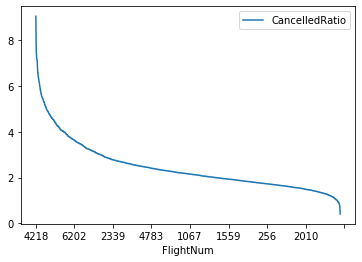

In [25]:
df_pd_FlightNum, catg_selected_FlightNum, plot_ = \
    select_catg("FlightNum", sql_text1, threshhold=7.0, qty_must_larger_than_med=True)

In [26]:
df_pd_FlightNum.head()

,FlightNum,Qty_Cancelled,Qty,CancelledRatio
59,4218,210,2317,9.06
60,4511,199,2201,9.04
77,4380,221,2620,8.44
84,4093,198,2381,8.32
98,4508,182,2285,7.96


In [27]:
def MarkElse(col_name, catg_selected):
    global df, new_COLS_CATAG
    # 把影響比較不顯著的值改成 'ELSE'
    print(f"修改前 [{col_name}] 種類數量:", df.select(col_name).distinct().count())
    udf_MarkElse = UserDefinedFunction(lambda x: x if x in catg_selected else "ELSE", StringType())
    df = df.withColumn(col_name+"_m", udf_MarkElse(col_name))
    new_COLS_CATAG.append(col_name+"_m")
    print(f"修改後 [{col_name+'_m'}] 種類數量:", df.select(col_name+"_m").distinct().count())

In [28]:
MarkElse("FlightNum", catg_selected_FlightNum)

修改前 [FlightNum] 種類數量: 7965
修改後 [FlightNum_m] 種類數量: 21


### Origin

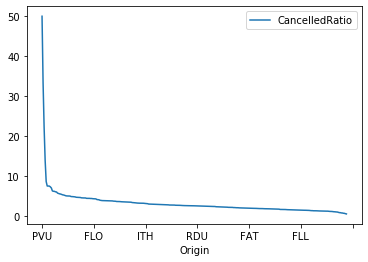

In [29]:
df_pd_Origin, catg_selected_Origin, plot_ = \
    select_catg("Origin", sql_text1, threshhold=5.0, qty_must_larger_than_med=False)

In [30]:
df_pd_Origin.head()

,Origin,Qty_Cancelled,Qty,CancelledRatio
0,PVU,1,2,50.00
1,PUB,1,3,33.33
2,DUT,611,2752,22.20
3,ORH,178,1281,13.90
4,ACK,57,662,8.61


In [31]:
MarkElse("Origin", catg_selected_Origin)

修改前 [Origin] 種類數量: 301
修改後 [Origin_m] 種類數量: 26


### Dest

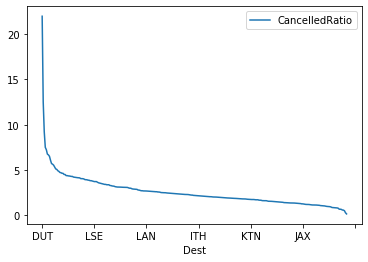

In [32]:
df_pd_Dest, catg_selected_Dest, plot_ = \
    select_catg("Dest", sql_text1, threshhold=5.0, qty_must_larger_than_med=False)

In [33]:
df_pd_Dest.head()

,Dest,Qty_Cancelled,Qty,CancelledRatio
0,DUT,605,2752,21.98
1,ORH,160,1279,12.51
2,ACK,61,662,9.21
3,ADK,21,280,7.50
4,ADQ,311,4298,7.24


In [34]:
MarkElse("Dest", catg_selected_Dest)

修改前 [Dest] 種類數量: 305
修改後 [Dest_m] 種類數量: 16


### UniqueCarrier

[UniqueCarrier] 種類數量: 22


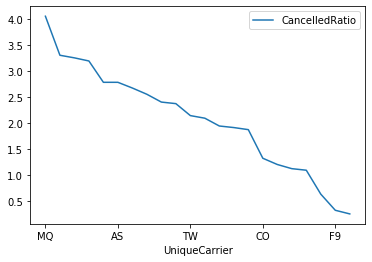

In [35]:
df_pd_UniqueCarrier = spark.sql(sql_text1.format(colname="UniqueCarrier")).toPandas()
print("[UniqueCarrier] 種類數量:", df_pd_UniqueCarrier.shape[0]) 
df_pd_UniqueCarrier.plot('UniqueCarrier','CancelledRatio')

In [36]:
df_pd_UniqueCarrier.to_csv(f"stat/col[UniqueCarrier]_stat.csv")

In [37]:
print("此欄位不修改")
new_COLS_CATAG.append('UniqueCarrier')

此欄位不修改


In [38]:
df.createOrReplaceTempView("df")
df.take(1)

[Row(Year=2000, UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=28, DayOfWeek=5, CRSDepTime=1647, CRSArrTime=1859, CRSElapsedTime=252, Distance=1587, Cancelled=0, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, CRSArrTime_f=4.969825267791748, CRSElapsedTime_f=0.7504915595054626, Month_f=0.5235987901687622, DayofMonth_f=5.675135135650635, DayOfWeek_f=4.48798942565918, Month_sin=0.5000000126183913, DayofMonth_sin=-0.5712681990994033, DayOfWeek_sin=-0.974927894498283, CRSDepTime_sin=-0.9496991722700603, CRSArrTime_sin=-0.9670458822044172, FlightNum_m='ELSE', Origin_m='ELSE', Dest_m='ELSE')]

### class_weight

In [39]:
weightNonCanceled = df.where("Cancelled=1").count()/df.count()
print("班機取消的比例: ", weightNonCanceled )

班機取消的比例:  0.022466050051270794


In [40]:
udf_weight_class = UserDefinedFunction(lambda x: 1-weightNonCanceled if x==1 else weightNonCanceled , FloatType())
df = df.withColumn("class_weight", udf_weight_class("Cancelled"))

In [41]:
df.where("Cancelled=1").take(1)

[Row(Year=2000, UniqueCarrier='HP', Origin='ATL', Dest='PHX', FlightNum='154', Month=1, DayofMonth=30, DayOfWeek=7, CRSDepTime=1647, CRSArrTime=1859, CRSElapsedTime=252, Distance=1587, Cancelled=1, Distance_norm=0.3198307156562805, CRSDepTime_f=4.393866539001465, CRSArrTime_f=4.969825267791748, CRSElapsedTime_f=0.7504915595054626, Month_f=0.5235987901687622, DayofMonth_f=6.080502033233643, DayOfWeek_f=6.2831854820251465, Month_sin=0.5000000126183913, DayofMonth_sin=-0.2012983995478517, DayOfWeek_sin=1.7484556000744883e-07, CRSDepTime_sin=-0.9496991722700603, CRSArrTime_sin=-0.9670458822044172, FlightNum_m='ELSE', Origin_m='ELSE', Dest_m='ELSE', class_weight=0.9775339365005493)]

In [42]:
sql_text2 = """select YY.{colname} , YY.Qty, XX.Qty_NotCancelled, XX.Qty_Cancelled, round(XX.Qty_Cancelled/YY.Qty,4) as CancelledRatio
              from ((select {colname} as YearX, count({colname}) as Qty_NotCancelled from df where Cancelled=0 group by {colname}) X 
              join (select {colname} as YearY, count({colname}) as Qty_Cancelled from df where Cancelled=1 group by {colname}) Y on X.{colname}X=Y.{colname}Y) XX
              join (select {colname}, count({colname}) as Qty from df group by {colname}) YY on XX.{colname}X=YY.{colname}
            order by YY.{colname}"""
dataset_info = spark.sql(sql_text2.format(colname="Year")).toPandas()
dataset_info.to_csv("dataset_info.csv")
dataset_info

,Year,Qty,Qty_NotCancelled,Qty_Cancelled,CancelledRatio
0,2000,5682778,5495547,187231,0.0329
1,2001,5967780,5736582,231198,0.0387
2,2002,5271359,5206216,65143,0.0124
3,2003,6488539,6387070,101469,0.0156
4,2004,7129270,7001513,127757,0.0179
5,2005,7140596,7006866,133730,0.0187


# 建立模型

ref: https://weiminwang.blog/2016/06/09/pyspark-tutorial-building-a-random-forest-binary-classifier-on-unbalanced-dataset/

ref: https://spark.apache.org/docs/latest/ml-tuning.html

In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [44]:
new_COLS_CATAG, new_COLS_FLOAT #檢查有沒有重複的 col_name

(['FlightNum_m', 'Origin_m', 'Dest_m', 'UniqueCarrier'],
 ['Distance_norm',
  'Month_f',
  'Month_sin',
  'DayofMonth_f',
  'DayofMonth_sin',
  'DayOfWeek_f',
  'DayOfWeek_sin',
  'CRSDepTime_f',
  'CRSDepTime_sin',
  'CRSArrTime_f',
  'CRSArrTime_sin',
  'CRSElapsedTime_f'])

## 資料pipeline

In [45]:
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)).setHandleInvalid("keep")#"skip", "keep", "error"
    for c in new_COLS_CATAG
]
encoder = OneHotEncoderEstimator(
        inputCols=[indexer.getOutputCol() for indexer in indexers],
        outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)
vectorAssembler = VectorAssembler(
    inputCols=encoder.getOutputCols()+new_COLS_FLOAT, 
    outputCol="features"
)

In [46]:
%%time
pipeline = Pipeline(stages=indexers+[encoder, vectorAssembler]).fit(df)
allData = pipeline.transform(df)

CPU times: user 43.4 ms, sys: 9.7 ms, total: 53.1 ms
Wall time: 58.4 s


In [47]:
print("Distribution of Pos and Neg in allData is: ", allData.groupBy(LABEL_COL).count().take(3))#check

Distribution of Pos and Neg in allData is:  [Row(Cancelled=1, count=846528), Row(Cancelled=0, count=36833794)]


In [48]:
#del df
trainingData = allData.where(f"Year!=2005")#.cache()
testData = allData.where(f"Year=2005")

In [49]:
print("Distribution of Pos and Neg in trainingData is: ", trainingData.groupBy(LABEL_COL).count().take(3))
print("Distribution of Pos and Neg in trainingData is: ", testData.groupBy(LABEL_COL).count().take(3))

Distribution of Pos and Neg in trainingData is:  [Row(Cancelled=1, count=712798), Row(Cancelled=0, count=29826928)]
Distribution of Pos and Neg in trainingData is:  [Row(Cancelled=1, count=133730), Row(Cancelled=0, count=7006866)]


## LR 模型

In [50]:
evaluator = BinaryClassificationEvaluator(
    labelCol=LABEL_COL, 
    rawPredictionCol="prediction", 
    metricName="areaUnderROC")

In [52]:
lr = LogisticRegression(maxIter=10, elasticNetParam=0.0, fitIntercept=True)  \
    .setWeightCol("class_weight") \
    .setLabelCol(LABEL_COL) \
    .setFeaturesCol("features")

paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.001, 1e-4, 1e-5, 1e-6]) \
    .build()

### tvs - 訓練

In [53]:
%%time
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid_lr,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
tvs = tvs.fit(trainingData)
bestModel_tvs = tvs.bestModel #取得最佳模型

CPU times: user 366 ms, sys: 117 ms, total: 483 ms
Wall time: 3min 3s


In [54]:
tvs.save("lr_tvs")

In [56]:
java_model =bestModel_tvs._java_obj #印出最佳參數
{param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid_lr[0]}

{'regParam': 1e-05}

### tvs - 驗證模型

In [57]:
predicted = bestModel_tvs.transform(testData).select('probability', LABEL_COL, "prediction").collect()

In [59]:
%%time
tp = sum([(i[2]==1.0) and (i[1]==1) for i in predicted])
fp = sum([(i[2]==1.0) and (i[1]==0) for i in predicted])
tn = sum([(i[2]==0.0) and (i[1]==0) for i in predicted])
fn = sum([(i[2]==0.0) and (i[1]==1) for i in predicted])
tp, fp, tn, fn

CPU times: user 22.4 s, sys: 112 ms, total: 22.5 s
Wall time: 22.6 s


(83366, 3074028, 3932838, 50364)

In [65]:
r = tp / (tp + fn)
p =  tp / (tp + fp)
f1 = 2/(1/r+1/p)
metrics = spark.createDataFrame([
 ("TP", float(tp)),
 ("FP", float(fp)),
 ("TN", float(tn)),
 ("FN", float(fn)),
 ("Precision", p ),
 ("Recall", r),
 ("F1-Score", f1)], ["metric", "value"])
metrics.show()

+---------+--------------------+
|   metric|               value|
+---------+--------------------+
|       TP|             83366.0|
|       FP|           3074028.0|
|       TN|           3932838.0|
|       FN|             50364.0|
|Precision|0.026403420035636983|
|   Recall|  0.6233904135197786|
| F1-Score| 0.05066111152299336|
+---------+--------------------+



In [66]:
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in predicted]

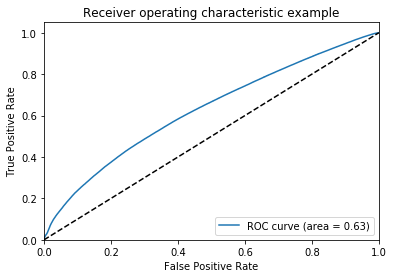

In [67]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### cv - 訓練

In [68]:
%%time
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=evaluator,
                    numFolds=5)  # use 3+ folds in practice
cv = cv.fit(trainingData)
bestModel_cv = cv.bestModel #取得最佳模型

CPU times: user 1.93 s, sys: 472 ms, total: 2.4 s
Wall time: 12min 18s


In [69]:
cv.write().overwrite().save("lr_cv")

In [70]:
java_model =bestModel_cv._java_obj #印出最佳參數
{param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
    for param in paramGrid_lr[0]}

{'regParam': 0.0001}

### cv - 驗證模型

In [76]:
predicted = bestModel_cv.transform(testData).select('probability', LABEL_COL, "prediction").collect()

In [77]:
%%time
tp = sum([(i[2]==1.0) and (i[1]==1) for i in predicted])
fp = sum([(i[2]==1.0) and (i[1]==0) for i in predicted])
tn = sum([(i[2]==0.0) and (i[1]==0) for i in predicted])
fn = sum([(i[2]==0.0) and (i[1]==1) for i in predicted])
tp, fp, tn, fn

CPU times: user 22.4 s, sys: 20.1 ms, total: 22.5 s
Wall time: 22.5 s


(83374, 3074216, 3932650, 50356)

In [78]:
r = tp / (tp + fn)
p =  tp / (tp + fp)
f1 = 2/(1/r+1/p)
metrics = spark.createDataFrame([
 ("TP", float(tp)),
 ("FP", float(fp)),
 ("TN", float(tn)),
 ("FN", float(fn)),
 ("Precision", p ),
 ("Recall", r),
 ("F1-Score", f1)], ["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            83374.0|
|       FP|          3074216.0|
|       TN|          3932650.0|
|       FN|            50356.0|
|Precision|0.02640431468303358|
|   Recall| 0.6234502355492411|
| F1-Score|0.05066295589611463|
+---------+-------------------+



In [79]:
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in predicted]

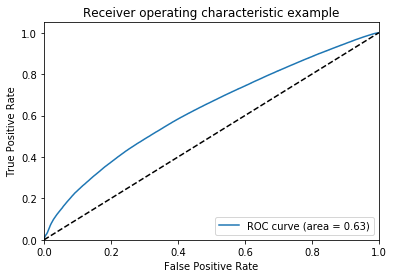

In [80]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## RF 模型